In [1]:
!pip install catboost scorecardpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=8fea015abc4bfd0cc39f57368b9d250d71a4dc0c74fd3d3dc056ea57d375a19d
  Stored in directory: /root/.cache/pip/wheels/18/b9/40/9fc7fa3ee628a20fb571991f96d54997cfbfab13e752bacd84
Successfully built scorecardpy


In [2]:
# Libray untuk manipulasi serta visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
import warnings

# Library untuk data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import chi2, SelectKBest
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.metrics import auc

# Library untuk modeling dan evaluation
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, mean_squared_error

# Library untuk menyesuaikan format sebelum deploy
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import pickle

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("ggplot")
warnings.filterwarnings('ignore')
%matplotlib inline

# Business Understanding


Yobank adalah sebuah perusahaan digital bank yang sedang memasarkan produk terbarunya, yaitu pinjaman atau credit loan. Secara umum, bank harus melakukan mitigasi risiko sebelum memasarkan produknya secara luas, untuk menghindari kerugian yang tentunya tidak diinginkan. Untuk kasus credit loan ini, penting sekali bagi bank untuk mengetahui apakah calon customer layak mendapatkan loan atau tidak, sebagai bentuk mitigasi risiko. Untuk memenuhi kebutuhan ini, bank telah melakukan testing pinjaman, dan telah mengumpulkan data aplikasi, yaitu data yang berisi informasi customer yang diberikan pinjaman, serta data yang berisi status pembayaran pada bulan tertentu. Dari kedua data ini, akan dibangun model yang dapat memprediksi apakah seorang customer termasuk “good” customer atau “bad” customer, dimana “good” customer adalah customer yang diprediksi untuk masih dapat membayar pinjaman sehingga akan diberikan pinjaman tersebut. Sebaliknya, “bad” customer adalah customer yang diprediksi tidak dapat membayar pinjaman. Untuk pengkategorian ini, didefinisikan “bad” customer sebagai customer yang terlambat bayar selama lebih dari 60 hari (2 bulan).


# Data Understanding

In [3]:
app = pd.read_csv("/content/application_record.csv")

In [4]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
# Cek jumlah baris dan kolom
app.shape

(438557, 18)

In [ ]:
# Cek tipe data tiap kolom
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
# Cek pemusatan data untuk kolom numerik
app.describe(exclude = "object")

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [ ]:
# Cek pemusatan data untuk kolom kategorik
app.describe(include = "object")

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
count,438557,438557,438557,438557,438557,438557,438557,304354
unique,2,2,2,5,5,5,6,18
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,294440,275459,304074,226104,301821,299828,393831,78240


In [ ]:
# Cek jumlah missing values pada masing-masing kolom
app.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [ ]:
# Cek jumlah baris duplikat
# Terdapat data entri dengan fitur sama namun dengan ID berbeda
app.iloc[:, 1:].duplicated().sum()

348472

In [ ]:
app[app.iloc[:, 1:].duplicated()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438550,6840100,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438551,6840102,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


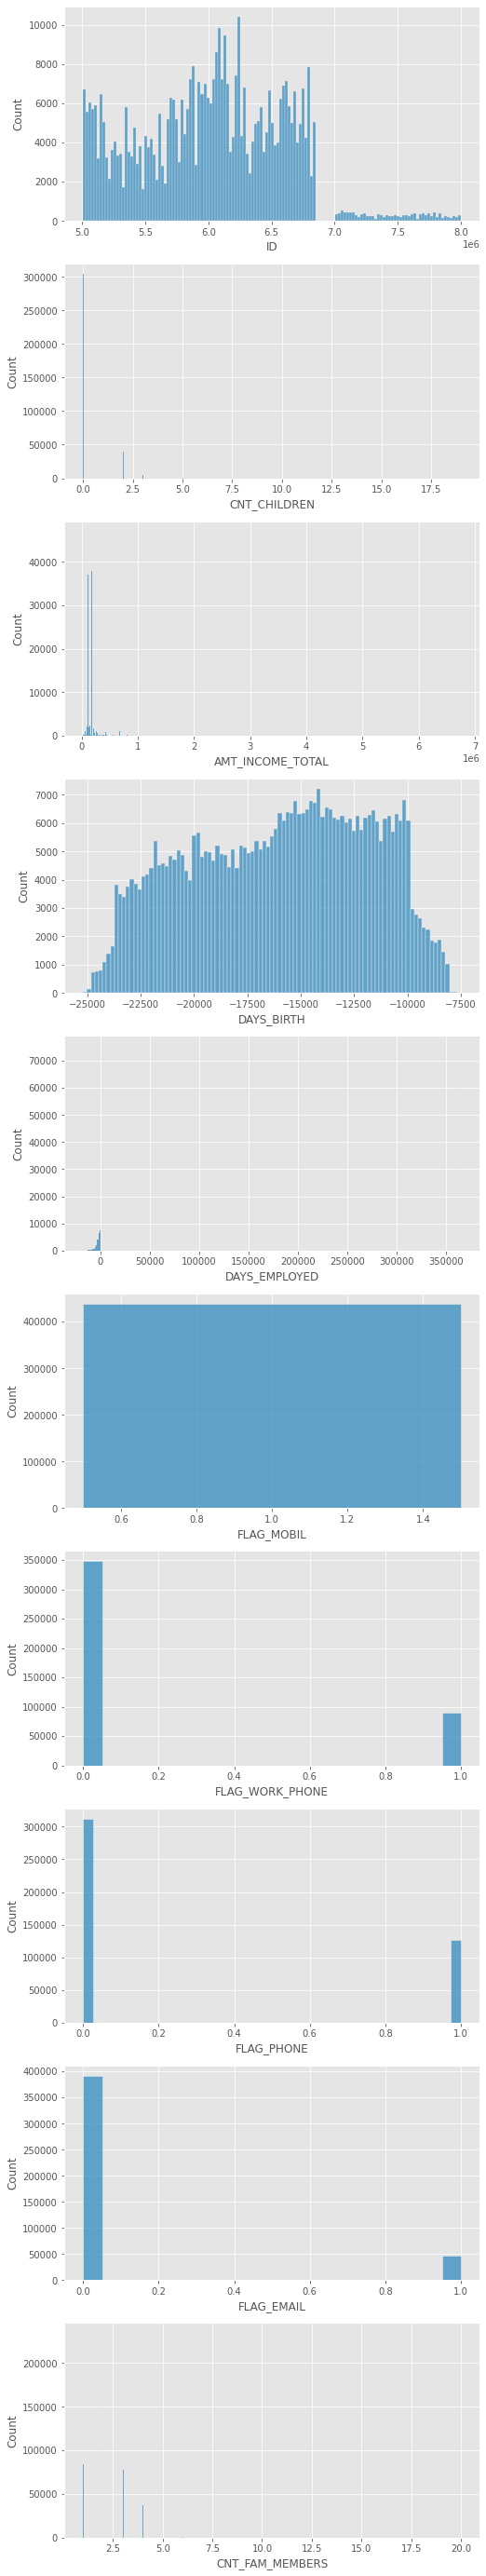

In [6]:
# Cek distribusi untuk variabel numerik
fig, ax = plt.subplots(10, 1, figsize = (8, 50))
ax = ax.flatten() 

for i, j in enumerate(app.select_dtypes(["int", "float"]).columns):
  sns.histplot(app[j], label = "numerik", ax = ax[i])

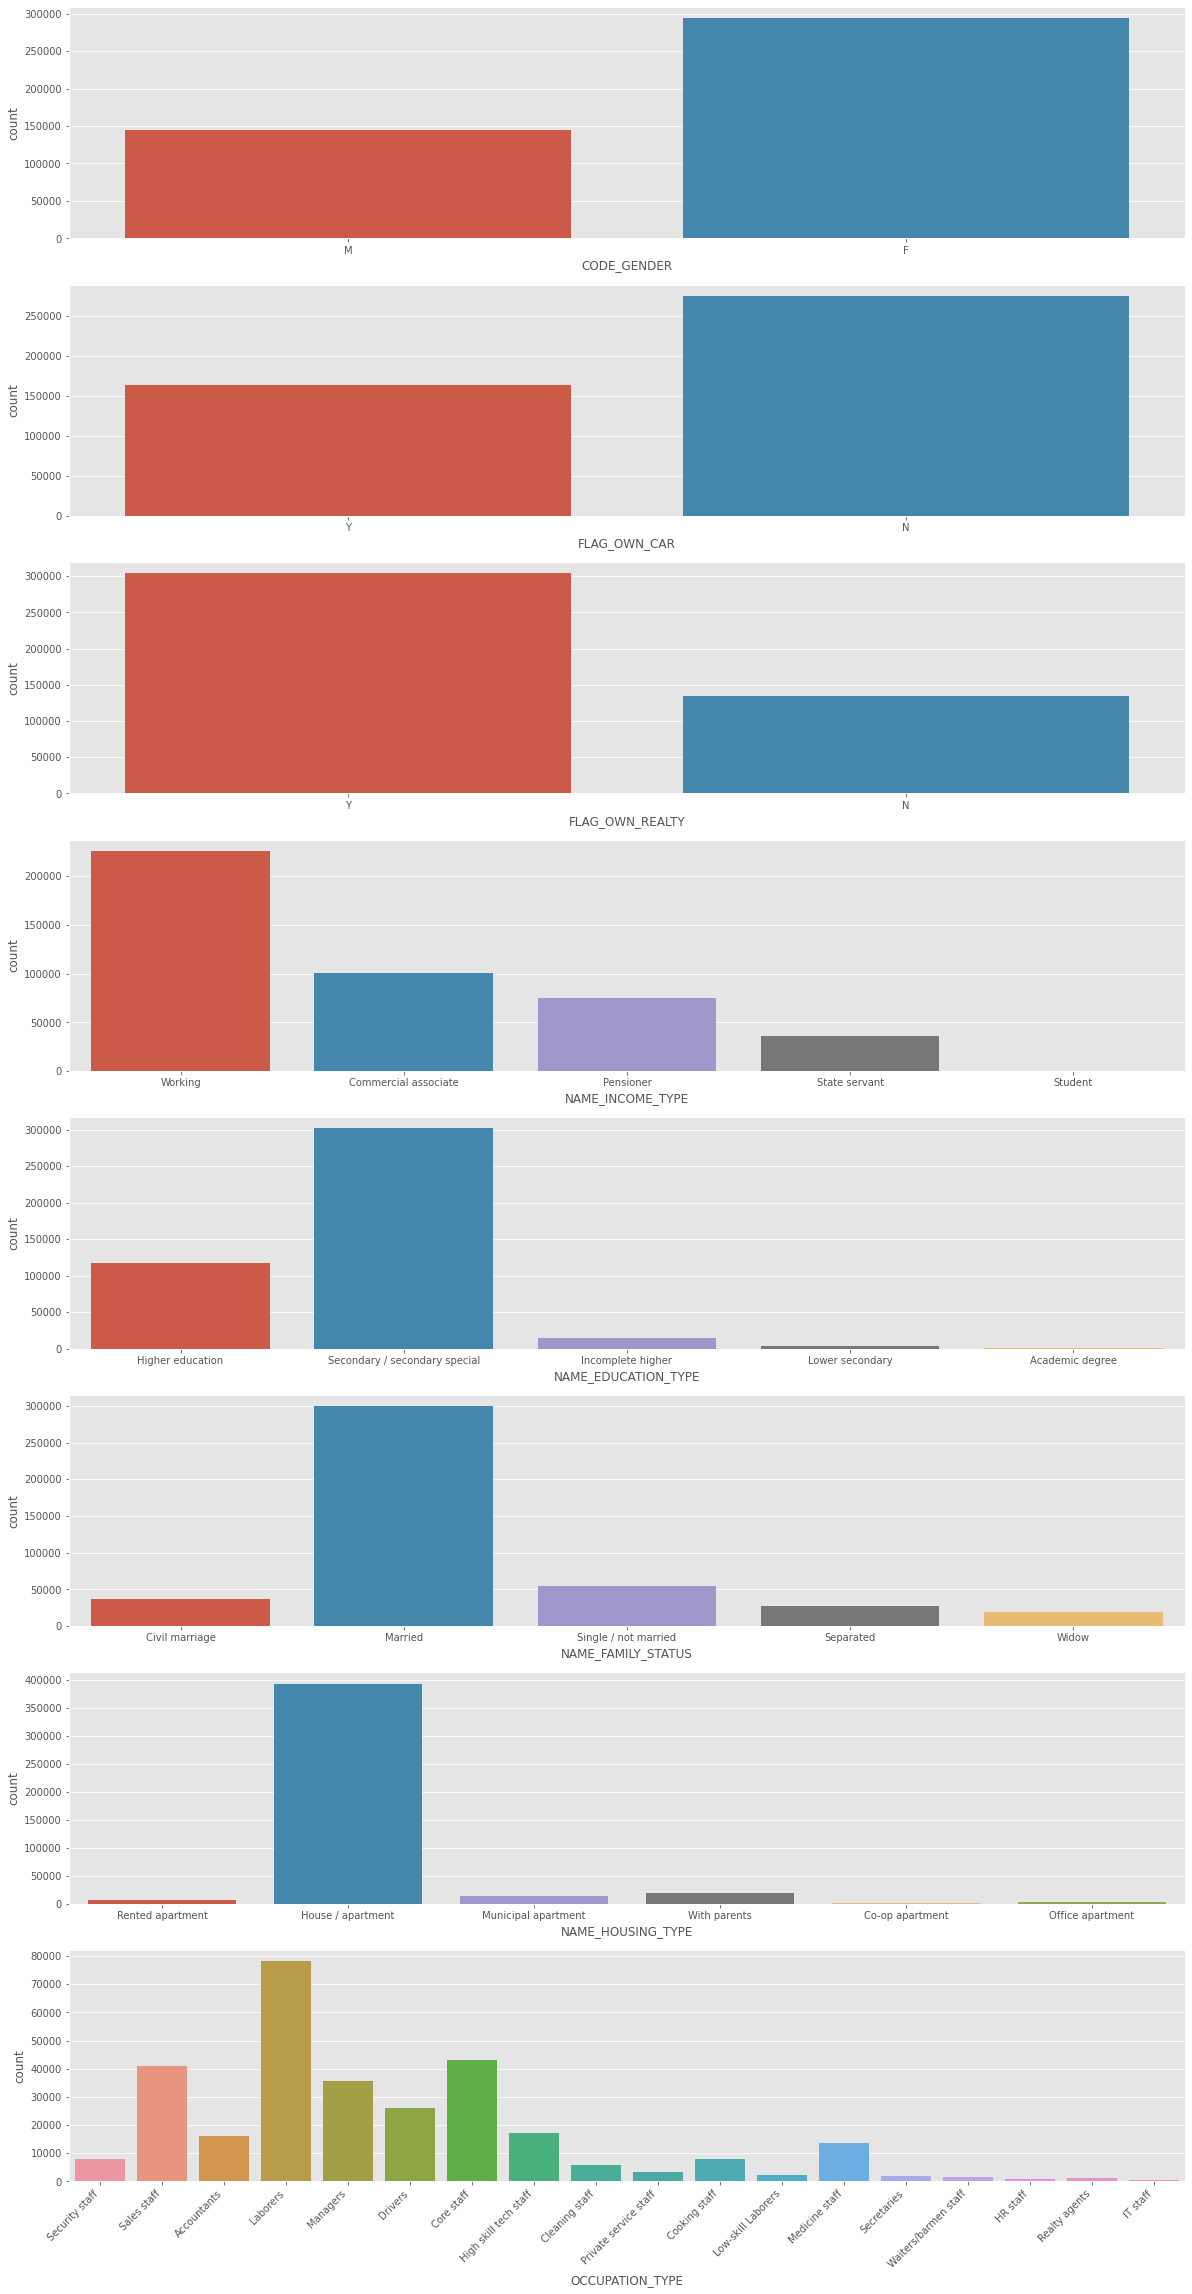

In [ ]:
# Check data distribution using countplot for categoric features
fig, ax = plt.subplots(8, 1, figsize = (20, 40))
ax = ax.flatten() 

for i, j in enumerate(app.select_dtypes(["object"]).columns):
  sns.countplot(app[j], label = "categoric", ax = ax[i])
  plt.xticks(rotation= 45, ha = 'right')

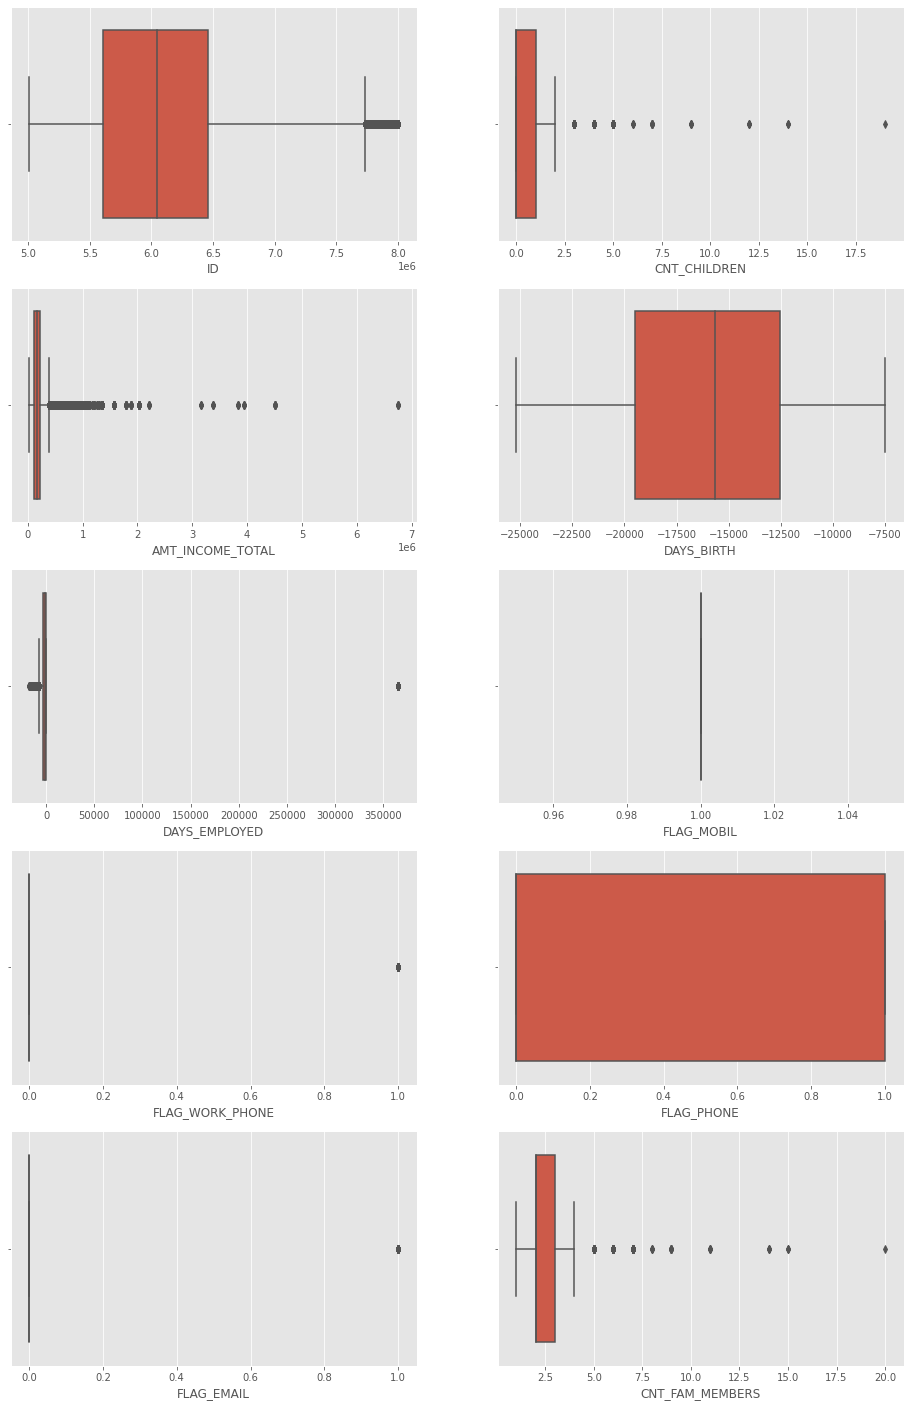

In [ ]:
# Cek outlier pada kolom numerik
fig, ax = plt.subplots(5, 2, figsize = (16, 25))
ax = ax.flatten() 

for i, j in enumerate(app.select_dtypes(["float", "int"]).columns):
  sns.boxplot(app[j], ax = ax[i])

In [ ]:
credit = pd.read_csv("/content/credit_record.csv")

In [ ]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
# Cek jumlah baris dan kolom
credit.shape

(1048575, 3)

In [ ]:
# Cek tipe data tiap kolom
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [ ]:
# Cek pemusatan data untuk kolom numerik
credit.describe(exclude = "object")

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [ ]:
# Cek pemusatan data untuk kolom kategorik
credit.describe(include = "object")

,STATUS
count,1048575
unique,8
top,C
freq,442031


In [ ]:
# Cek jumlah missing values pada masing-masing kolom
credit.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [ ]:
# Cek jumlah baris duplikat
credit.duplicated().sum()

0

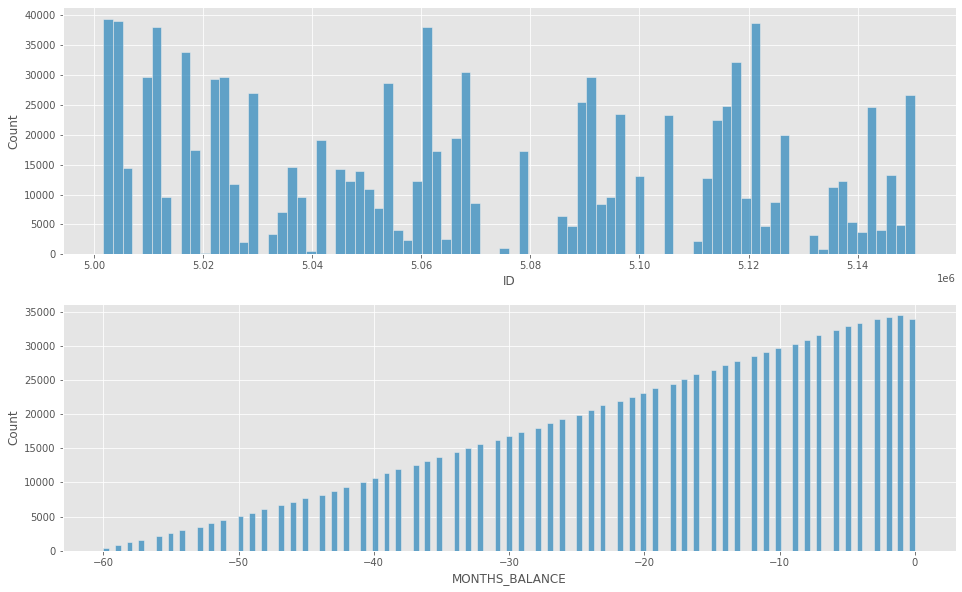

In [ ]:
# Cek distribusi untuk variabel numerik
fig, ax = plt.subplots(2, 1, figsize = (16, 10))
ax = ax.flatten() 

for i, j in enumerate(credit.select_dtypes('int').columns):
  sns.histplot(credit[j], label = "numerik", ax = ax[i])

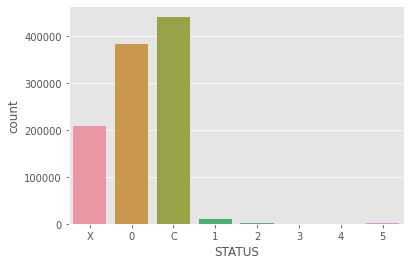

In [ ]:
# Cek distribusi untuk variabel kategorik
sns.countplot(credit["STATUS"]);

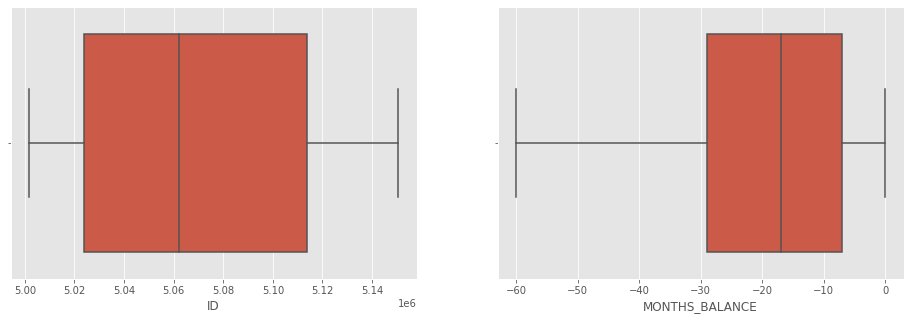

In [ ]:
# Cek outlier pada kolom numerik
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten() 

for i, j in enumerate(credit.select_dtypes('int').columns):
  sns.boxplot(credit[j], ax = ax[i])

# Data Preparation

In [ ]:
# Handle nilai duplikat pada app terlebih dahulu
# Nilai duplikat dapat membuat model training lama dan menurunkan variansi dataset
app.drop_duplicates(subset = app.columns[1:], keep = "first", inplace = True)
app.reset_index(drop = True, inplace = True)
app.iloc[:, 1:].duplicated().sum()

0

In [ ]:
# Handle missing value pada kolom OCCUPATION_TYPE app
imputer = SimpleImputer(strategy = "constant", fill_value = "Missing")
app_new = pd.DataFrame(imputer.fit_transform(app), columns = app.columns)
app_new.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

In [ ]:
# Kita akan mencoba melakukan klasifikasi untuk menentukan nilai missing value
train = app_new.query("OCCUPATION_TYPE != 'Missing'")
test = app_new.query("OCCUPATION_TYPE == 'Missing'")

In [ ]:
train.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0
5,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-17778,-1194,1,0,0,0,Laborers,2.0
6,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0


In [ ]:
train.drop("ID", axis = 1, inplace = True)

In [ ]:
train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0
5,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-17778,-1194,1,0,0,0,Laborers,2.0
6,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0


In [ ]:
# Mendefinisikan variabel dependen dan independen
X = train.copy()
y = X.pop("OCCUPATION_TYPE")

In [ ]:
# Melakukan label encoding variabel kategorik
for i in X.select_dtypes("object").columns:
  label = LabelEncoder()
  X[i] = label.fit_transform(X[i])
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
1,1,1,1,0,174,4,4,1,1,1192,7855,0,0,0,0,1
2,0,0,1,0,473,0,4,3,1,3276,5940,0,0,1,1,0
4,1,1,1,0,473,4,1,1,1,5480,8220,0,1,1,1,1
5,1,1,1,0,238,0,4,1,1,4588,7795,0,0,0,0,1
6,0,1,0,0,225,4,2,1,1,11662,7886,0,0,0,0,1


In [ ]:
X.shape

(62608, 16)

In [ ]:
# Melakukan train_test_split X dan y
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [ ]:
model = CatBoostClassifier(iterations = 100, eval_metric = "MultiClass", early_stopping_rounds = 5)
model.fit(X_train, y_train)
preds = model.predict(X_valid)
print(classification_report(y_valid, preds))

Learning rate set to 0.5
0:	learn: 2.1575271	total: 265ms	remaining: 26.2s
1:	learn: 2.0063430	total: 429ms	remaining: 21s
2:	learn: 1.9472476	total: 622ms	remaining: 20.1s
3:	learn: 1.9246083	total: 793ms	remaining: 19s
4:	learn: 1.9080546	total: 964ms	remaining: 18.3s
5:	learn: 1.8939193	total: 1.14s	remaining: 17.9s
6:	learn: 1.8862466	total: 1.33s	remaining: 17.6s
7:	learn: 1.8815194	total: 1.5s	remaining: 17.2s
8:	learn: 1.8770350	total: 1.66s	remaining: 16.8s
9:	learn: 1.8705670	total: 1.82s	remaining: 16.4s
10:	learn: 1.8656410	total: 1.99s	remaining: 16.1s
11:	learn: 1.8620020	total: 2.18s	remaining: 16s
12:	learn: 1.8565382	total: 2.34s	remaining: 15.7s
13:	learn: 1.8531844	total: 2.52s	remaining: 15.5s
14:	learn: 1.8500947	total: 2.68s	remaining: 15.2s
15:	learn: 1.8468590	total: 2.85s	remaining: 14.9s
16:	learn: 1.8442290	total: 3.01s	remaining: 14.7s
17:	learn: 1.8403878	total: 3.18s	remaining: 14.5s
18:	learn: 1.8375851	total: 3.35s	remaining: 14.3s
19:	learn: 1.8342190	to

In [ ]:
# Setelah model sudah kita train maka kita dapat melakukan prediksi pada test set
# Sebelum itu kita sesuaikan formatnya
test.drop(["ID", "OCCUPATION_TYPE"], axis = 1, inplace = True)

for i in test.select_dtypes("object").columns:
  label = LabelEncoder()
  test[i] = label.fit_transform(test[i])

test.reset_index(drop = True, inplace = True)
test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,1,1,1,0,448,4,1,0,4,9824,1438,0,1,0,0,1
1,0,0,1,0,388,1,1,2,1,2016,5000,0,0,0,0,0
2,0,0,1,1,217,4,4,3,1,10490,3550,0,0,0,0,1
3,0,0,1,0,407,1,4,4,1,4220,5000,0,0,0,0,0
4,1,0,1,1,361,4,4,1,1,10938,2558,0,0,0,0,2


In [ ]:
test.shape

(27477, 16)

In [ ]:
predictions = model.predict(test)
test["OCCUPATION_TYPE"] = predictions

In [ ]:
test.to_csv("Prediksi.csv", index = False)

In [ ]:
test = pd.read_csv("/content/Prediksi.csv")

In [ ]:
test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,OCCUPATION_TYPE
0,1,1,1,0,448,4,1,0,4,9824,1438,0,1,0,0,1,Laborers
1,0,0,1,0,388,1,1,2,1,2016,5000,0,0,0,0,0,Core staff
2,0,0,1,1,217,4,4,3,1,10490,3550,0,0,0,0,1,Laborers
3,0,0,1,0,407,1,4,4,1,4220,5000,0,0,0,0,0,Medicine staff
4,1,0,1,1,361,4,4,1,1,10938,2558,0,0,0,0,2,Laborers


In [ ]:
# Memasukkan campuran prediksi serta mode OCCUPATION_TYPE ke app
app["OCCUPATION_TYPE"].fillna(test["OCCUPATION_TYPE"], inplace = True)
app.fillna(app["OCCUPATION_TYPE"].describe()[2], inplace = True)

In [ ]:
# Cek apakah sudah tidak ada missing values
app.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

In [ ]:
app.shape

(90085, 18)

In [ ]:
# Melakukan merge atau penggabungan kedua dataset dengan key ID
df = pd.merge(credit, app, how = "inner", on = "ID")
df.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0


In [ ]:
df.shape

In [ ]:
df["ID"].nunique()

9709

In [ ]:
# Membuat fitur target (good atau bad) berdasarkan fitur status
df["TARGET"] = df["STATUS"].apply(lambda x: "good" if x in ['X', '0', 'C', '1'] else "bad")

In [ ]:
df.head(20)

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
5,5008804,-5,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
6,5008804,-6,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
7,5008804,-7,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
8,5008804,-8,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
9,5008804,-9,C,M,Y,Y,0,427500.0,Working,Higher education,...,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good


In [ ]:
df[df["ID"] == 5008806]

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
16,5008806,0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
17,5008806,-1,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
18,5008806,-2,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
19,5008806,-3,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
20,5008806,-4,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
21,5008806,-5,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
22,5008806,-6,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
23,5008806,-7,X,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
24,5008806,-8,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
25,5008806,-9,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good


In [ ]:
# Drop kolom yang sudah tidak diperlukan serta duplikat lalu reset index
df.drop(["MONTHS_BALANCE", "STATUS"], axis = 1, inplace = True)
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace =True)

In [ ]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,good
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Medicine staff,1.0,good
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,good


In [ ]:
df.shape

(9915, 19)

In [ ]:
# Mencari data dengan target ganda
target_counts = pd.DataFrame(df.groupby("ID")["TARGET"].count().sort_values(ascending = False))
duplicate_target = target_counts[target_counts["TARGET"] == 2].index

In [ ]:
# Membuat index menjadi ID
df.index = df["ID"]
df.drop("ID", axis = 1, inplace = True)

In [ ]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
ID,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,good
5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Medicine staff,1.0,good
5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,good


In [ ]:
df.loc[duplicate_target, :]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
ID,,,,,,,,,,,,,,,,,,
5078801,F,N,Y,0,306000.0,Working,Secondary / secondary special,Married,House / apartment,-18927,-2978,1,0,0,0,High skill tech staff,2.0,bad
5078801,F,N,Y,0,306000.0,Working,Secondary / secondary special,Married,House / apartment,-18927,-2978,1,0,0,0,High skill tech staff,2.0,good
5113685,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-12379,-4453,1,0,0,1,Sales staff,2.0,good
5113685,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-12379,-4453,1,0,0,1,Sales staff,2.0,bad
5096069,F,Y,N,0,180000.0,Working,Higher education,Married,House / apartment,-14943,-1650,1,1,0,0,Core staff,2.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065742,F,Y,Y,0,225000.0,Pensioner,Higher education,Married,House / apartment,-21955,365243,1,0,1,0,Core staff,2.0,bad
5090216,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-10712,-217,1,0,0,0,Laborers,2.0,good
5090216,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-10712,-217,1,0,0,0,Laborers,2.0,bad


In [ ]:
# Mengambil salah satu data dari duplikat yang memiliki target bad
bad = df.loc[duplicate_target, :].query("TARGET == 'bad'")
bad["ID"] = bad.index

In [ ]:
# Menghilangkan data duplikat
df.drop(df.loc[duplicate_target, :].index, inplace = True)

In [ ]:
# Menjadikan ID kembali menjadi fitur lalu mencari berapa ID unik
df["ID"] = df.index
df.reset_index(drop = True, inplace = True)

In [ ]:
# Menambahkan bad pada df sehingga salah satu dari duplikat tersimpan
df = pd.concat([df, bad], axis = 0)
df.reset_index(drop = True, inplace = True)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,ID
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good,5008804
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good,5008806
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,good,5008808
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Medicine staff,1.0,good,5008812
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,good,5008815


In [ ]:
df["ID"].nunique()

9709

In [ ]:
df.shape

(9709, 19)

In [ ]:
df.drop("ID", axis = 1, inplace = True)

In [ ]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0,good
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,good
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,good
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Medicine staff,1.0,good
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,good


In [ ]:
# Melakukan sedikit feature engineering untuk menghasilkan fitur praktikal dan bermanfaat
# Nilai unik fitur FLAG_MOBIL hanya satu sehingg bisa dihilangkan
df.drop("FLAG_MOBIL", axis = 1, inplace = True)

# Fitur seperti DAYS_BIRTH bisa kita ubah ke fitur yang lebih praktis seperti AGE atau umur
# Sedangkan fitur DAYS_EMPLOYED yang menyatakan lama bekerja bisa kita ubah ke tahun yang lebih praktis
# Fitur-fitur seperti DAYS_BIRTH dan DAYS_EMPLOYED kemudian bisa dihilangkan supaya tidak ada multikolinearitas fitur
df["AGE"] = np.round(np.abs(df["DAYS_BIRTH"]) / 365.25)
df["WORKING_YEARS"] = np.round(np.abs(df["DAYS_EMPLOYED"]) / 365.25)
df.drop(["DAYS_BIRTH", "DAYS_EMPLOYED"], axis = 1, inplace = True)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Laborers,2.0,good,33.0,12.0
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,good,59.0,3.0
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,good,52.0,8.0
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Medicine staff,1.0,good,62.0,1000.0
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,good,46.0,2.0


In [ ]:
# Terdapat anomali working years yang sampai 1000 tahun, setelah dilihat ternyata adalah orang yang sudah pensiun
df[df["WORKING_YEARS"] > 800]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Medicine staff,1.0,good,62.0,1000.0
16,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0,0,0,Core staff,1.0,good,55.0,1000.0
24,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,2.0,good,61.0,1000.0
34,F,N,N,0,255150.0,Pensioner,Incomplete higher,Civil marriage,Rented apartment,0,0,0,Laborers,2.0,good,51.0,1000.0
40,F,N,Y,0,94500.0,Pensioner,Higher education,Married,House / apartment,0,1,0,Core staff,2.0,good,61.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9701,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,2.0,bad,59.0,1000.0
9702,F,Y,Y,0,162000.0,Pensioner,Higher education,Married,House / apartment,0,1,0,Laborers,2.0,bad,57.0,1000.0
9703,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,Laborers,2.0,bad,58.0,1000.0
9705,F,N,N,0,90000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0,0,0,Laborers,2.0,bad,59.0,1000.0


In [ ]:
# Untuk menangani anomali tersebut bisa dengan membuat model regresi linear sederhana, dengan AGE sebagai prediktor
X = df[df["WORKING_YEARS"]  < 800][["WORKING_YEARS", "AGE"]].copy()
y = X.pop("WORKING_YEARS")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 7)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_valid)
print("RMSE:", np.sqrt(mean_squared_error(preds, y_valid)))

predictions = model.predict(np.array(df[df["WORKING_YEARS"] > 800]["AGE"]).reshape(1696, -1)).round()

predictions = pd.Series(predictions)

RMSE: 5.869098643561939


In [ ]:
# Memasukkan prediksi kedalam dataset awal df
df = pd.concat([df, predictions], axis = 1)
df["WORKING_YEARS"] = df["WORKING_YEARS"].apply(lambda x: np.nan if x == 1000.0 else x)
df["WORKING_YEARS"].fillna(df[0], inplace = True)
df["WORKING_YEARS"].fillna(12, inplace = True)
df.drop(0, axis = 1, inplace = True)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Laborers,2.0,good,33.0,12.0
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,good,59.0,3.0
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,good,52.0,8.0
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Medicine staff,1.0,good,62.0,9.0
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,good,46.0,2.0


In [6]:
# Save data hasil cleansing dan merge
df.to_csv("data clean.csv", index = False)

In [ ]:
# Membuat copy df
df_new = df.copy()

In [5]:
df_new = pd.read_csv("/content/data clean.csv")

In [7]:
df_new.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Laborers,2.0,good,33.0,12.0
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,good,59.0,3.0
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,good,52.0,8.0
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Medicine staff,1.0,good,62.0,9.0
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,good,46.0,2.0


In [ ]:
# Mengubah variabel kategorik dataframe hasil merge ke numerik menggunakan LabelEncoder()
# Serta melakukan print hasil pemetaan variabel kategorik
for i in df_new.select_dtypes("object").columns:
  label = LabelEncoder()
  df_new[i] = label.fit_transform(df_new[i])
  mapping = dict(zip(label.classes_, label.transform(label.classes_)))
  print(mapping)
df_new.head()

{'F': 0, 'M': 1}
{'N': 0, 'Y': 1}
{'N': 0, 'Y': 1}
{'Commercial associate': 0, 'Pensioner': 1, 'State servant': 2, 'Student': 3, 'Working': 4}
{'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Secondary / secondary special': 4}
{'Civil marriage': 0, 'Married': 1, 'Separated': 2, 'Single / not married': 3, 'Widow': 4}
{'Co-op apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2, 'Office apartment': 3, 'Rented apartment': 4, 'With parents': 5}
{'Accountants': 0, 'Cleaning staff': 1, 'Cooking staff': 2, 'Core staff': 3, 'Drivers': 4, 'HR staff': 5, 'High skill tech staff': 6, 'IT staff': 7, 'Laborers': 8, 'Low-skill Laborers': 9, 'Managers': 10, 'Medicine staff': 11, 'Private service staff': 12, 'Realty agents': 13, 'Sales staff': 14, 'Secretaries': 15, 'Security staff': 16, 'Waiters/barmen staff': 17}
{'bad': 0, 'good': 1}


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
0,1,1,1,0,427500.0,4,1,0,4,1,0,0,8,2.0,1,33.0,12.0
1,1,1,1,0,112500.0,4,4,1,1,0,0,0,16,2.0,1,59.0,3.0
2,0,0,1,0,270000.0,0,4,3,1,0,1,1,14,1.0,1,52.0,8.0
3,0,0,1,0,283500.0,1,1,2,1,0,0,0,11,1.0,1,62.0,9.0
4,1,1,1,0,270000.0,4,1,1,1,1,1,1,0,2.0,1,46.0,2.0


In [ ]:
# Menyimpan hasil pemetaan kedalam dictionary
CODE_GENDER = {'F': 0, 'M': 1}
FLAG_OWN_CAR = {'N': 0, 'Y': 1}
FLAG_OWN_REALTY = {'N': 0, 'Y': 1}
NAME_INCOME_TYPE = {'Commercial associate': 0, 'Pensioner': 1, 'State servant': 2, 'Student': 3, 'Working': 4}
NAME_EDUCATIONAL_TYPE = {'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Secondary / secondary special': 4}
NAME_FAMILY_STATUS = {'Civil marriage': 0, 'Married': 1, 'Separated': 2, 'Single / not married': 3, 'Widow': 4}
NAME_HOUSING_TYPE = {'Co-op apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2, 'Office apartment': 3, 'Rented apartment': 4, 'With parents': 5}
OCCUPATION_TYPE = {'Accountants': 0, 'Cleaning staff': 1, 'Cooking staff': 2, 'Core staff': 3, 'Drivers': 4, 'HR staff': 5, 'High skill tech staff': 6, 'IT staff': 7, 'Laborers': 8, 'Low-skill Laborers': 9, 'Managers': 10, 'Medicine staff': 11, 'Private service staff': 12, 'Realty agents': 13, 'Sales staff': 14, 'Secretaries': 15, 'Security staff': 16, 'Waiters/barmen staff': 17}

In [ ]:
# Karena tujuan model kita adalah menentukan bad customer yang akan gagal bayar, maka good:0 dan bad:1
df_new["TARGET"] = df_new["TARGET"].apply(lambda x: 1 if x in [0, "bad"] else 0)

In [ ]:
df_new.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,WORKING_YEARS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Laborers,2.0,0,33.0,12.0
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,59.0,3.0
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52.0,8.0
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Medicine staff,1.0,0,62.0,9.0
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,46.0,2.0


In [ ]:
# Melakukan feature selection dengan korelasi Pearson terhadap TARGET
np.abs(df_new.corr().iloc[14,:]).sort_values(ascending = False)

TARGET                 1.000000
NAME_FAMILY_STATUS     0.044790
FLAG_OWN_REALTY        0.029428
CODE_GENDER            0.027231
AGE                    0.018863
NAME_INCOME_TYPE       0.015221
OCCUPATION_TYPE        0.013932
CNT_CHILDREN           0.012023
FLAG_EMAIL             0.010203
FLAG_WORK_PHONE        0.010032
WORKING_YEARS          0.007653
AMT_INCOME_TOTAL       0.007313
FLAG_PHONE             0.005905
FLAG_OWN_CAR           0.005553
NAME_HOUSING_TYPE      0.003425
CNT_FAM_MEMBERS        0.002006
NAME_EDUCATION_TYPE    0.001595
Name: TARGET, dtype: float64

In [ ]:
# Melakukan feature selection dengan SelectKBest dengan scoring function chi2
X = df_new.copy()
y = X.pop("TARGET")

bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(X, y)

In [ ]:
scores = pd.DataFrame(fit.scores_, index = X.columns)
pd.DataFrame(scores[0].sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,28235.882023
NAME_FAMILY_STATUS,13.285541
AGE,10.681749
CODE_GENDER,4.688783
OCCUPATION_TYPE,4.376474
NAME_INCOME_TYPE,2.882096
FLAG_OWN_REALTY,2.761720
WORKING_YEARS,2.728377
CNT_CHILDREN,1.952779
FLAG_EMAIL,0.922251


In [ ]:
# Melakukan feature selection dengan ExtraTreeClassifier
X = df_new.copy()
y = X.pop("TARGET")

model = ExtraTreesClassifier()
model.fit(X, y)

ExtraTreesClassifier()

In [ ]:
print(model.feature_importances_)

[0.01792911 0.02588456 0.01729733 0.04975508 0.17445624 0.05007528
 0.03888102 0.05637728 0.0293481  0.01825525 0.02598528 0.01429799
 0.10354804 0.083194   0.17356242 0.12115302]


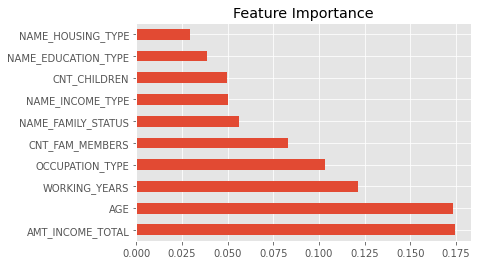

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = "barh")
plt.title("Feature Importance");

[INFO] creating woe binning ...


{'CNT_FAM_MEMBERS': <Figure size 432x288 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure size 432x288 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 432x288 with 2 Axes>,
 'AGE': <Figure size 432x288 with 2 Axes>,
 'CNT_CHILDREN': <Figure size 432x288 with 2 Axes>,
 'FLAG_OWN_REALTY': <Figure size 432x288 with 2 Axes>,
 'FLAG_EMAIL': <Figure size 432x288 with 2 Axes>,
 'WORKING_YEARS': <Figure size 432x288 with 2 Axes>,
 'CODE_GENDER': <Figure size 432x288 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'FLAG_PHONE': <Figure size 432x288 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'AMT_INCOME_TOTAL': <Figure size 432x288 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 432x288 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 432x288 with 2 Axes>,
 'FLAG_WORK_PHONE': <Figure size 432x288 with 2 Axes>}

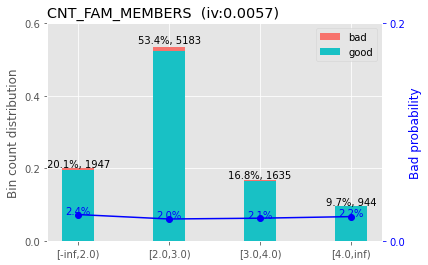

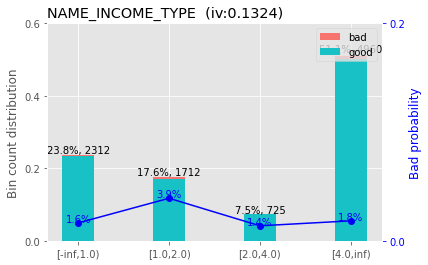

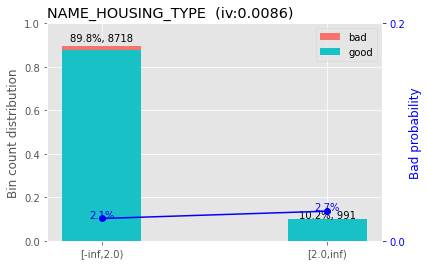

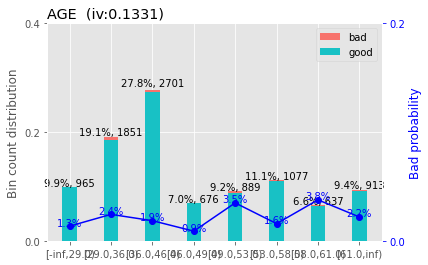

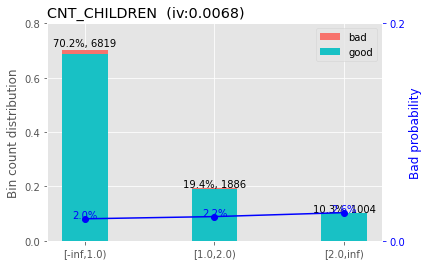

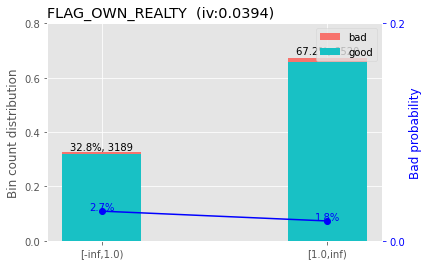

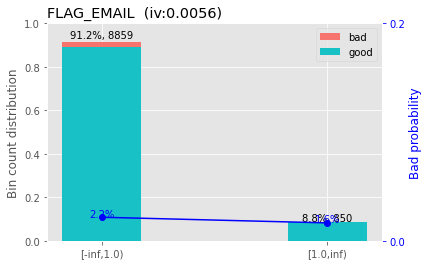

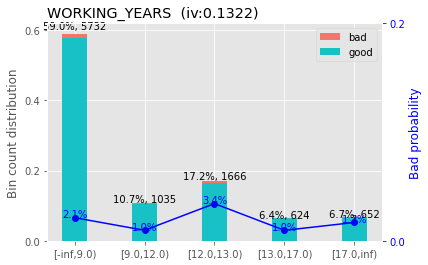

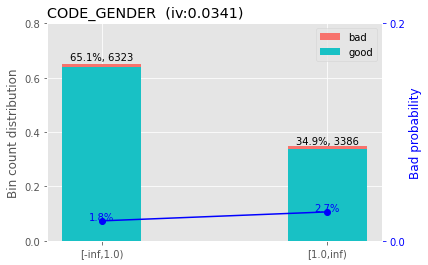

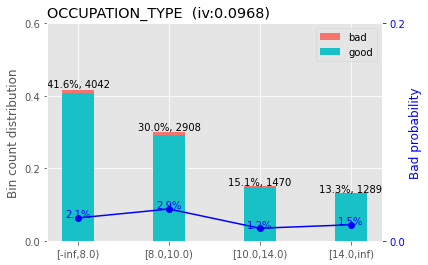

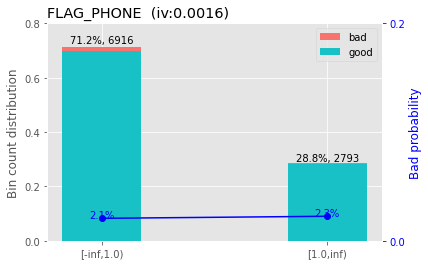

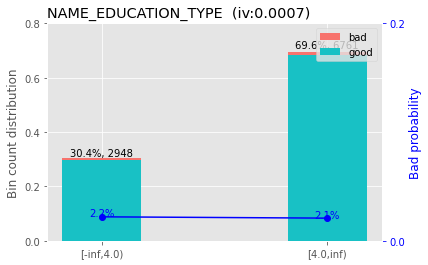

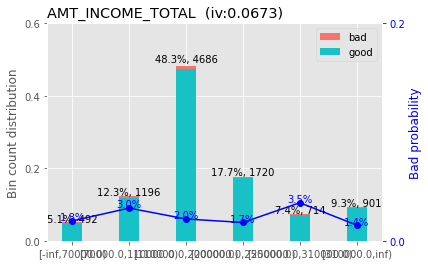

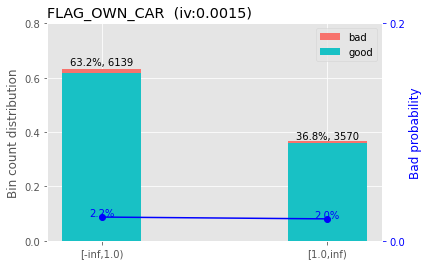

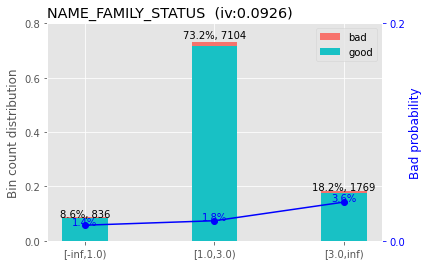

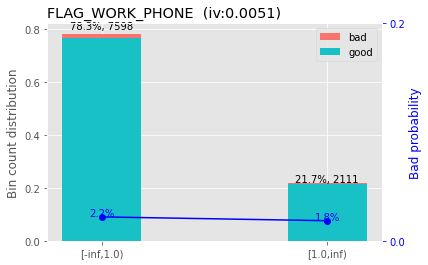

In [ ]:
# Melakukan feature selection menggunakn Weight of Evidence (WoE) dan Information Value (IV)
bins = sc.woebin(df_new, "TARGET")
sc.woebin_plot(bins)

In [18]:
# Berdasarkan feature selection yang sudah dilakukan, kita dapat 10 fitur terbaik
features = ["NAME_INCOME_TYPE", "AGE", "OCCUPATION_TYPE", "NAME_FAMILY_STATUS", 
            "WORKING_YEARS", "FLAG_OWN_REALTY", "CODE_GENDER", "AMT_INCOME_TOTAL", 
            "CNT_CHILDREN", "NAME_HOUSING_TYPE"]

# Lalu kita jadikan sebagai datafram baru untuk kita visualisasi
df_fix = df_new[features].copy()
df_fix["TARGET"] = df_new["TARGET"].copy()

# Prediction Model and Evaluation

## A. Exploratory Data Analysis

Disini kita akan mencoba membuat visualisasi bermanfaat dari hasil feature selection untuk memperoleh insights

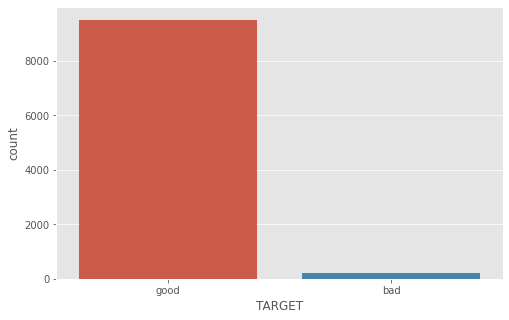

In [ ]:
# Jelas dataset yang kita punya adalah Imbalanced, lebih banyak good customer dibanding bad customer
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.countplot(df_fix["TARGET"]);

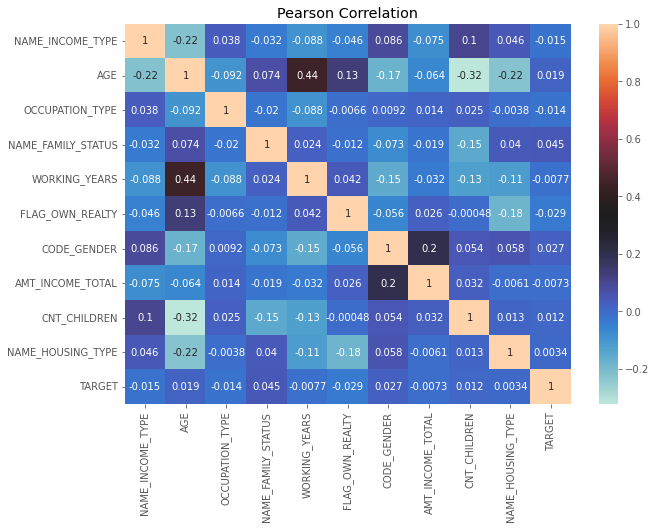

In [ ]:
# Dari heatmap dibawah, kita bisa melihat korelasi Pearson antar fitur terutama dengan TARGET
fig, ax = plt.subplots(1, 1, figsize = (10, 7))
sns.heatmap(df_fix.corr(), annot = True, cmap = "icefire")
plt.title("Pearson Correlation");

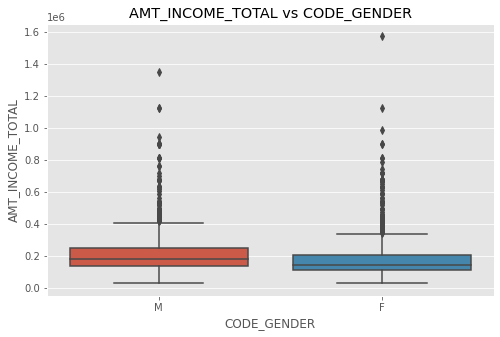

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "CODE_GENDER", y = "AMT_INCOME_TOTAL", data = df_fix)
plt.title("AMT_INCOME_TOTAL vs CODE_GENDER");

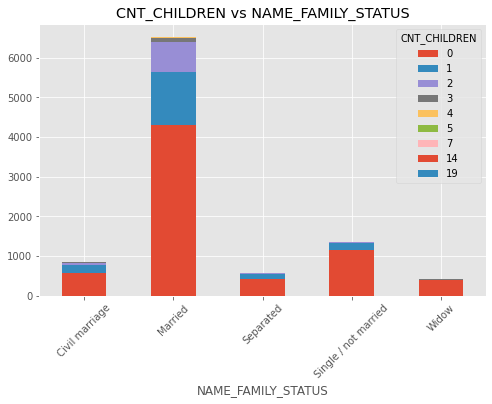

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
pd.crosstab(df_fix["NAME_FAMILY_STATUS"], df_fix["CNT_CHILDREN"]).plot(kind = "bar", stacked = True, ax = ax)
plt.title("CNT_CHILDREN vs NAME_FAMILY_STATUS")
plt.xticks(rotation = 45);

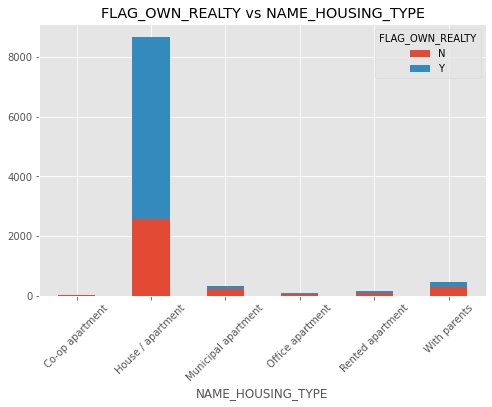

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
pd.crosstab(df_fix["NAME_HOUSING_TYPE"], df_fix["FLAG_OWN_REALTY"]).plot(kind = "bar", stacked = True, ax = ax)
plt.title("FLAG_OWN_REALTY vs NAME_HOUSING_TYPE")
plt.xticks(rotation = 45);

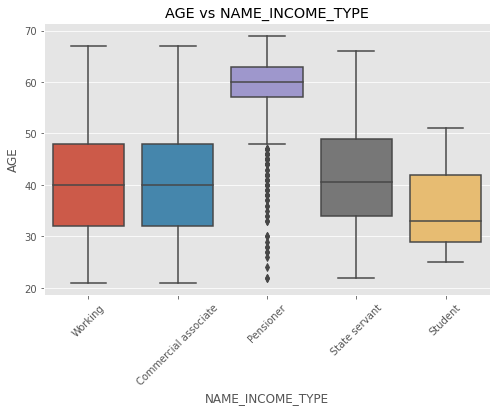

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "NAME_INCOME_TYPE", y = "AGE", data = df_fix)
plt.title("AGE vs NAME_INCOME_TYPE")
plt.xticks(rotation = 45);

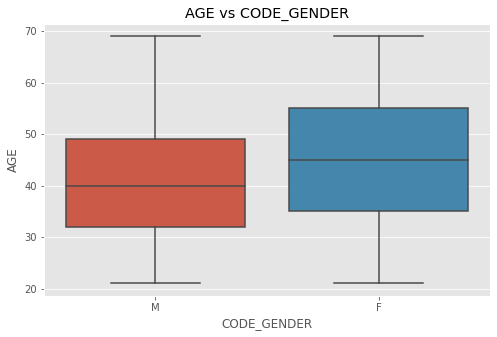

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "CODE_GENDER", y = "AGE", data = df_fix)
plt.title("AGE vs CODE_GENDER");

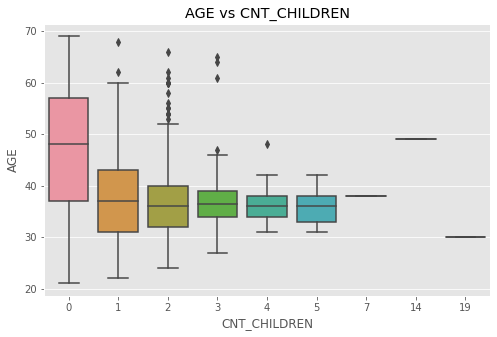

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "CNT_CHILDREN", y = "AGE", data = df_fix)
plt.title("AGE vs CNT_CHILDREN");

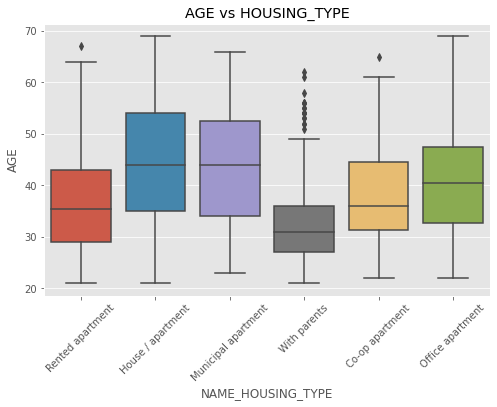

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "NAME_HOUSING_TYPE", y = "AGE", data = df_fix)
plt.title("AGE vs HOUSING_TYPE")
plt.xticks(rotation = 45);

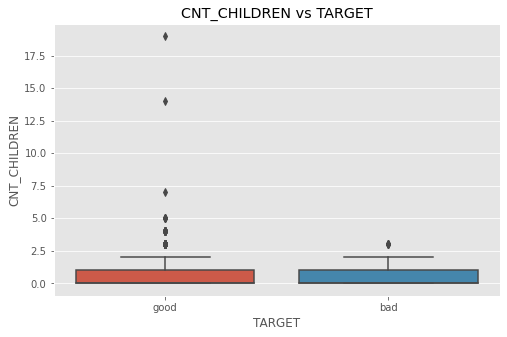

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "TARGET", y = "CNT_CHILDREN", data = df_fix)
plt.title("CNT_CHILDREN vs TARGET");

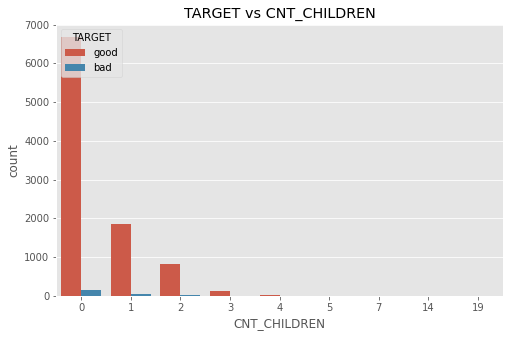

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.countplot(x = "CNT_CHILDREN", hue = "TARGET", data = df_fix)
plt.title("TARGET vs CNT_CHILDREN");

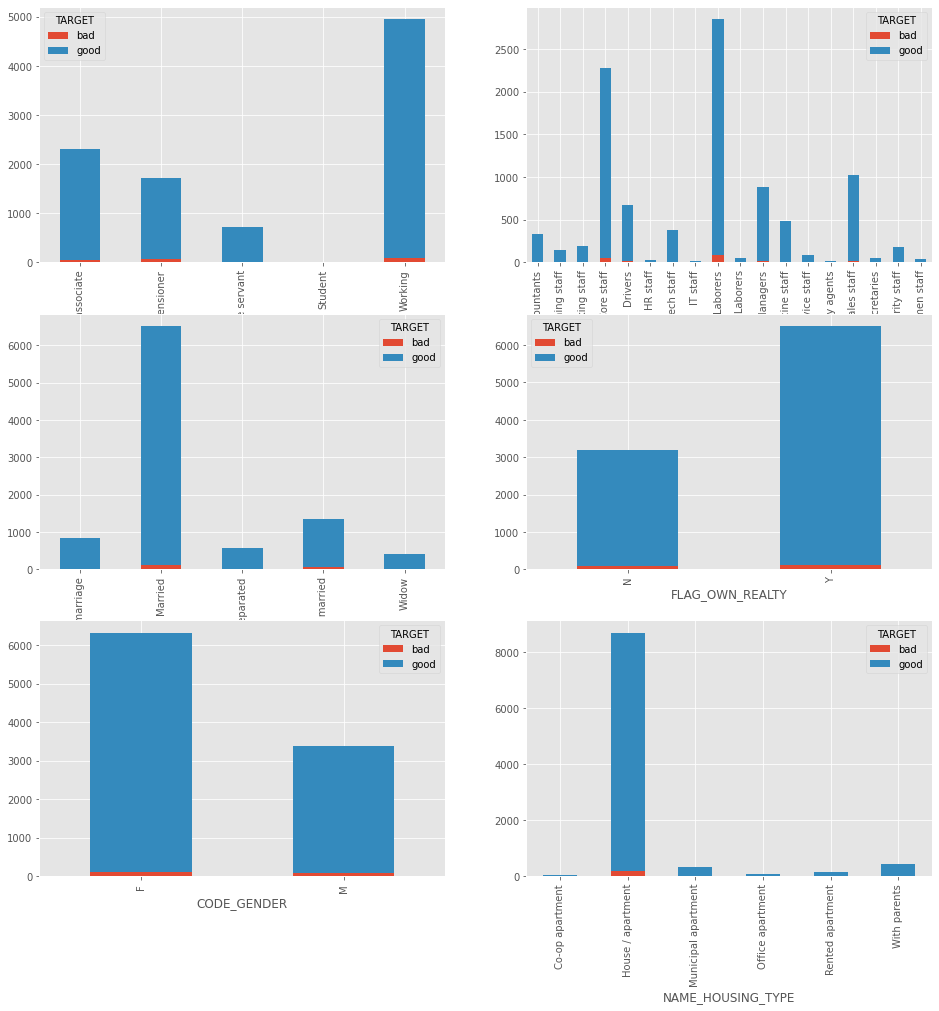

In [ ]:
# Kita bisa melihat bagaimana perbandingan target pada masing-masing nilai unik per kategori
# Terlihat bahwa mayoritas adalah good customer
fig, ax = plt.subplots(3, 2, figsize = (16, 16))
ax = ax.flatten() 

categoric = ["NAME_INCOME_TYPE", "OCCUPATION_TYPE", "NAME_FAMILY_STATUS", "FLAG_OWN_REALTY", 
             "CODE_GENDER", "NAME_HOUSING_TYPE"]

for i, j in enumerate(categoric):
  pd.crosstab(df_fix[j], df_fix["TARGET"]).plot(kind = "bar", stacked = True, ax = ax[i]);

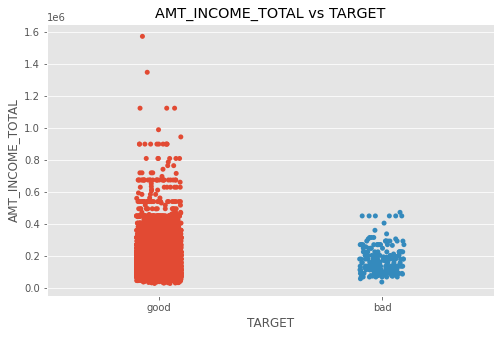

In [ ]:
# Orang dengan pendapatan tahunan rendah cenderung telat bayar
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.stripplot(x = "TARGET", y = "AMT_INCOME_TOTAL", data = df_fix)
plt.title("AMT_INCOME_TOTAL vs TARGET");

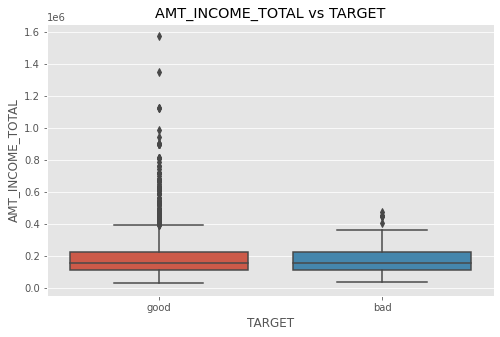

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "TARGET", y = "AMT_INCOME_TOTAL", data = df_fix)
plt.title("AMT_INCOME_TOTAL vs TARGET");

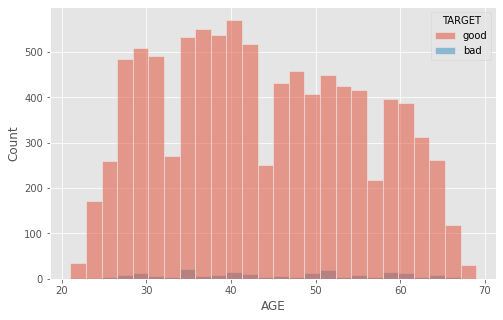

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.histplot(x = "AGE", hue = "TARGET", data = df_fix);

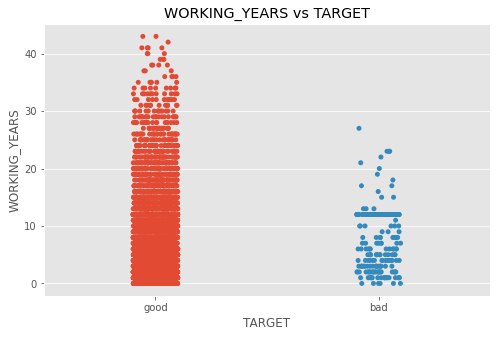

In [ ]:
# Orang yang belum lama bekerja cenderung telat bayar
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.stripplot(x = "TARGET", y = "WORKING_YEARS", data = df_fix)
plt.title("WORKING_YEARS vs TARGET");

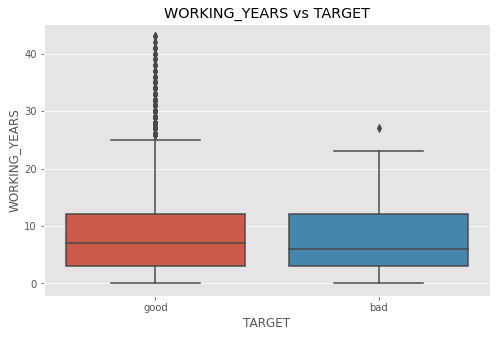

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.boxplot(x = "TARGET", y = "WORKING_YEARS", data = df_fix)
plt.title("WORKING_YEARS vs TARGET");

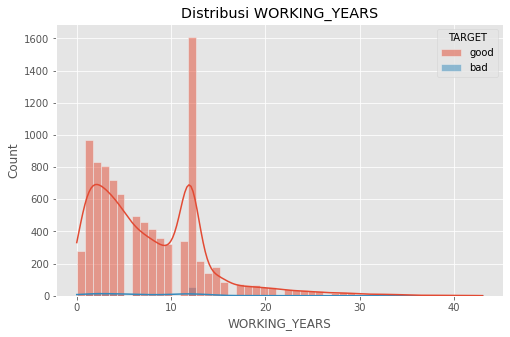

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.histplot(x = "WORKING_YEARS", hue = "TARGET", kde = True, data = df_fix)
plt.title("Distribusi WORKING_YEARS");

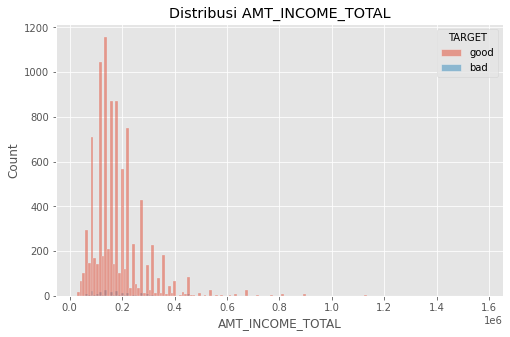

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.histplot(x = "AMT_INCOME_TOTAL", hue = "TARGET", data = df_fix)
plt.title("Distribusi AMT_INCOME_TOTAL");

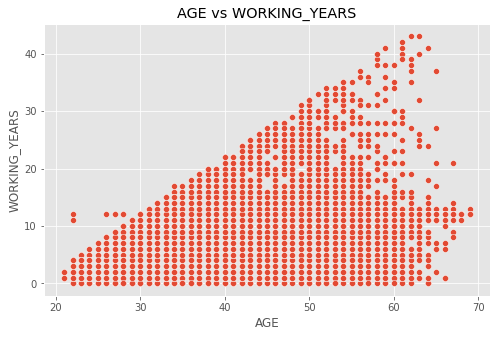

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(x = "AGE", y = "WORKING_YEARS", data = df_fix)
plt.title("AGE vs WORKING_YEARS");

## B. Modeling and Evaluation

*   Yobank adalah bank digital yang baru memasarkan produk barunya yaitu credit loan. Secara umum, bank harus melakukan ekspansi pasar dengan dana yang terbatas oleh karena itu penting sekali untuk mengetahui apakah customer pantas mendapat loan atau tidak.
*   Maka dari itu dibuat sebuah machine learning model berdasarkan data testing informasi dan payment behaviour dari customer pilihan untuk memprediksi bad customer yang akan gagal bayar pada masa mendatang (Target). Tentunya model machine learning tidak ada yang sempurna sehingga pasti ada konsekuensinya ketika misklasifikasi. Jika model salah memprediksi bad customer sebagai good customer (False Negative) maka tentu bank akan rugi. Sedangkan bila terjadi sebaliknya, yaitu salah memprediksi good customer sebagai bad customer (False Positive) bank kehilangan kesempatan untuk mendapat intereset/bunga dari customer yang merupakan sumber pendapatan paling utama bank pada umumnya.
*   Walaupun begitu, bank yang rugi sudah pasti lebih besar efeknya sehingga model kita akan diberikan bobot lebih besar dalam mengurangi False Negative. Oleh karena itu menurut kami metric evaluasi model machine learning yang pantas untuk menjawab business problem adalah F2 Score karena memperhitungkan baik Recall maupun Precision dengan Recall mendapat bobot lebih besar.

In [3]:
# Fungsi metrik model kita yaitu F2 Score
def f2(y_true, y_pred):
 return fbeta_score(y_true, y_pred, beta=2)

# Fungsi untuk melakukan Repeated Stratified K Fold Cross Validation
# Untuk evaluasi model dari out of sample data
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
	# define the model evaluation the metric
	metric = make_scorer(f2)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring = metric, cv = cv, n_jobs=-1)
	return scores

# Fungsi untuk mengambil model yang akan kita gunakan
def get_models():
  models, names = list(), list()
  # LGBM
  models.append(LGBMClassifier())
  names.append("LGBM")
  # XGB
  models.append(XGBClassifier())
  names.append("XGB")
  # RF
  models.append(RandomForestClassifier())
  names.append('RF')
  # CBC
  models.append(CatBoostClassifier(iterations = 200, eval_metric = "Recall", early_stopping_rounds = 5))
  names.append("CBC")
  return models, names

In [5]:
# Read kembali data sebelum pre processing
df_new = pd.read_csv("/content/data clean.csv")

for i in df_new.select_dtypes("object").columns:
  label = LabelEncoder()
  df_new[i] = label.fit_transform(df_new[i])

df_new["TARGET"] = df_new["TARGET"].apply(lambda x: 1 if x in [0, "bad"] else 0)

In [6]:
# Mendefinisikan variabel dependen dan independen sebagai input model
# Tujuan rename column hanya untuk menyesuaikan dengan input data nyata
features = ["NAME_INCOME_TYPE", "AGE", "OCCUPATION_TYPE", "NAME_FAMILY_STATUS", 
            "WORKING_YEARS", "FLAG_OWN_REALTY", "CODE_GENDER", "AMT_INCOME_TOTAL", 
            "CNT_CHILDREN", "NAME_HOUSING_TYPE"]
X = df_new[features].copy()
X.rename(columns = {"AGE":"DAYS_BIRTH", "WORKING_YEARS":"DAYS_EMPLOYED"}, inplace = True)
y = df_new["TARGET"].copy()

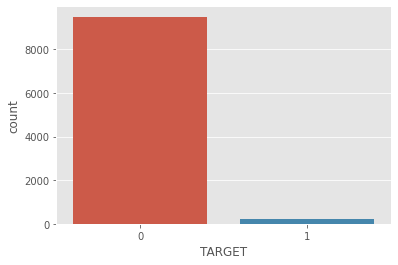

In [7]:
# Perlu kita ingat kembali bahwa target Imbalanced
sns.countplot(y);

In [8]:
# Untuk menangani dataset imbalanced bisa kita lakukan oversampling
# Yaitu kita akan sample kelas minoritas atau bad customer
smote = SMOTE(random_state = 42)
X_temp, y = smote.fit_resample(X, y)
X = pd.DataFrame(X_temp, columns = X.columns)

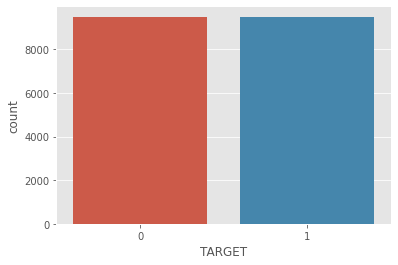

In [9]:
# Kita lihat kembali sekarang dataset balanced
sns.countplot(y);

In [ ]:
# Mendefinisikan model
models, names = get_models()
results = list()

# Evaluasi masing-masing model
for i in range(len(models)):
 # Evaluasi dan menyimpan hasil
 scores = evaluate_model(X, y, models[i])
 results.append(scores)
 # Meringkas perfoma model
 print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LGBM 0.979 (0.003)
>XGB 0.870 (0.009)
>RF 0.976 (0.004)
>CBC 0.983 (0.003)


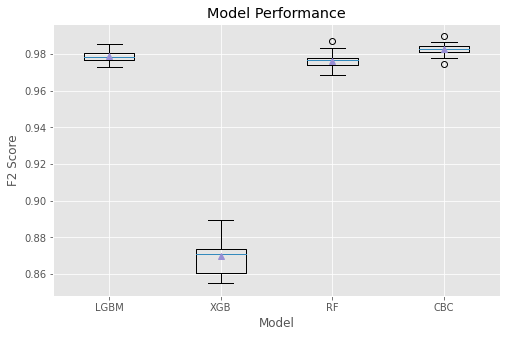

In [ ]:
plt.figure(figsize = (8, 5))
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Model Performance")
plt.xlabel("Model")
plt.ylabel("F2 Score");

F2 = 0.9833610648918469


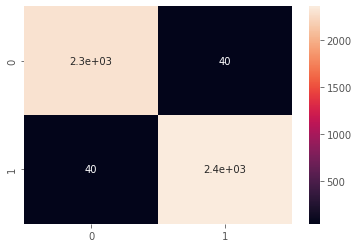

In [10]:
# Dari boxpolot diatas jelas CatBoostClassifier yang memiliki nilai F2 paling tinggi yaitu 0,983
# Melakukan train_test_split lalu fit dan predict mengggunakan CatBoostClassifier
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 9)
best_model = CatBoostClassifier(iterations = 200, eval_metric = "Recall", early_stopping_rounds = 5, verbose =False)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_valid)
print("F2 =", f2(preds, y_valid))
sns.heatmap(confusion_matrix(preds, y_valid), annot = True);

In [ ]:
# Sekarang kita harus menyesuaikan dengan data input nyata
# Karena seperti kita ketahui, data input berupakan angka dan text sedangkan model yang sudah kita train mengharuskan angka saja
# Untuk itu kita membuat suatu machinelearning pipeline untuk transformasi data terlebih dahulu lalu melakukan prediksi dengan best_model

# Data yang di feed ke pipeline untuk train adalah data mentah seperti di app dengan hanya mengambil fitur penting (hasil feature selection)
df_new = pd.read_csv("/content/data clean.csv")
df_new["TARGET"] = df_new["TARGET"].apply(lambda x: 1 if x in [0, "bad"] else 0)

features = ["NAME_INCOME_TYPE", "AGE", "OCCUPATION_TYPE", "NAME_FAMILY_STATUS", 
            "WORKING_YEARS", "FLAG_OWN_REALTY", "CODE_GENDER", "AMT_INCOME_TOTAL", 
            "CNT_CHILDREN", "NAME_HOUSING_TYPE"]

X = df_new[features].copy()
X.rename(columns = {"AGE":"DAYS_BIRTH", "WORKING_YEARS":"DAYS_EMPLOYED"}, inplace = True)
y = df_new["TARGET"].copy()

# Fungsi untuk konversi hari ke tahun
def to_years(x):
  return np.round(np.abs(x) / 365.35)

# Kita mendefiniskan suatu column transformer untuk mengubah data text atau variabel kategorik
# Selain itu seperti kita ketahui pada aplication records tidak ada fitur AGE dan WORKING YEARS
# Oleh karena itu harus kita lakukan transformasi DAYS_BIRTH dan DAYS_EMPLOYED
ct = make_column_transformer((OrdinalEncoder(), ["NAME_INCOME_TYPE", "OCCUPATION_TYPE", "NAME_FAMILY_STATUS", 
                                               "FLAG_OWN_REALTY", "CODE_GENDER", "NAME_HOUSING_TYPE"]), 
                             (FunctionTransformer(to_years), ["DAYS_BIRTH", "DAYS_EMPLOYED"]), remainder = "passthrough")

# Setelah itu kita gabungkan dengan model pada sebuah pipeline
pipeline = make_pipeline(ct, best_model)

# Untuk visualisasi pipeline
from sklearn import set_config
set_config(display = "diagram")

pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['NAME_INCOME_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'FLAG_OWN_REALTY',
                                                   'CODE_GENDER',
                                                   'NAME_HOUSING_TYPE']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function to_years at 0x7f3c5d253040>),
                                                  ['DAYS_BIRTH',
                                                   'DAYS_EMPLOYED'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3c5da74730>)])

In [ ]:
# Kita coba buktikan apakah pipeline kita dapat bekerja untuk input application records
# Yobank hanya butuh feature yang sudah kita tentukan sebelumnya
app_new = app[['NAME_INCOME_TYPE', 'DAYS_BIRTH', 'OCCUPATION_TYPE',
 'NAME_FAMILY_STATUS', 'DAYS_EMPLOYED', 'FLAG_OWN_REALTY',
 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE']].copy()

# Kita drop entri yang ada missing values dan reset_index
app_new.dropna(inplace = True)
app_new.reset_index(drop = True, inplace = True)

# Berikut kira-kira format data serta fitur yang dibutuhkan Yobank
app_new.head()

,NAME_INCOME_TYPE,DAYS_BIRTH,OCCUPATION_TYPE,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_REALTY,CODE_GENDER,AMT_INCOME_TOTAL,CNT_CHILDREN,NAME_HOUSING_TYPE
0,Working,-21474,Security staff,Married,-1134,Y,M,112500.0,0,House / apartment
1,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment
2,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment
3,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment
4,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment


In [ ]:
# Lalu kita lakukan prediksi dengan pipeline kita
predictions = pipeline.predict(app_new)
# Hasil prediksi kita buat sebagai fitur baru app_new
app_new["TARGET"] = predictions
# Kita lihat bahwa pipeline kita dapat menangani input data dan melakukan prediksi
app_new.head()

,NAME_INCOME_TYPE,DAYS_BIRTH,OCCUPATION_TYPE,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_REALTY,CODE_GENDER,AMT_INCOME_TOTAL,CNT_CHILDREN,NAME_HOUSING_TYPE,TARGET
0,Working,-21474,Security staff,Married,-1134,Y,M,112500.0,0,House / apartment,0
1,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment,0
2,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment,0
3,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment,0
4,Commercial associate,-19110,Sales staff,Single / not married,-3051,Y,F,270000.0,0,House / apartment,0


In [ ]:
# Menyimpan ml pipeline kita
with open("ml_pipline.pkl", "wb") as f:
  pickle.dump(pipeline, f)

In [ ]:
# Membuka ml pipeline kita
with open("ml_pipline.pkl", "rb") as f:
  pipeline = pickle.load(f)

In [ ]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['NAME_INCOME_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'FLAG_OWN_REALTY',
                                                   'CODE_GENDER',
                                                   'NAME_HOUSING_TYPE']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function to_years at 0x7f3c5d253040>),
                                                  ['DAYS_BIRTH',
                                                   'DAYS_EMPLOYED'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3c5dd2d6a0>)])

# Conclusion and Suggestion

## A. Conclusion


Dari proses exploratory data analysis, didapatkan kesimpulan atau insight mengenai bagaimana kecenderungan variabel/fitur terhadap kemampuan customer membayar pinjaman, yang dapat digunakan bank untuk penyesuaian program pinjaman, yaitu:  

*   Customer dengan pendapatan tahunan rendah cenderung telat bayar.
*   Customer yang belum lama bekerja cenderung telat bayar.
*   Customer yang tidak memiliki anak cenderung telat bayar.
*   Customer yang menikah cenderung telat bayar.
*   Customer yang memiliki profesi sebagai buruh dan pekerja kantoran cenderung telat bayar. 

Sedangkan dari proses modeling and evaluation, didapatkan kesimpulan terkait model machine learning yang dihasilkan, yaitu: 

*   Jenis task machine learning yang diselesaikan pada kegiatan analisis data ini yaitu klasifikasi. 
*   Metrik evaluasi yang digunakan yaitu F2 Score, untuk memberikan bobot lebih besar dalam mengurangi False Negative.
*   Algoritma classifier yang digunakan pada model machine learning yang dihasilkan yaitu CatBoostClassifier, karena memiliki F2 Score paling tinggi.
*   Model machine learning yang dihasilkan memiliki F2 Score sebesar 0,983 ± 0,003 sehingga target keberhasilan model (yaitu metric performance 0,7) telah terpenuhi.
*   Untuk menunjang efektivitas model, digunakan pipeline dengan tahapan awal pre-processing ordinal encoding yang mengubah variabel kategorik menjadi numerik dan penyesuaian fitur yang dibutuhkan model seperti AGE dan WORKING_YEARS sebelum dapat melakukan prediksi.

## B. Suggestion

Saran yang dapat diberikan kepada bank sebagai pihak yang akan menggunakan hasil kegiatan analisis data ini yaitu 


*   Konsisten mengumpulkan data setelah program testing pinjaman selesai, untuk evaluasi model secara berkala.
*   Memverifikasi setiap calon customer termasuk “good” customer sebelum menyetujui pinjaman.
*   Menyesuaikan program pinjaman pada golongan customer dengan kecenderungan “bad”, seperti membatasi limit pinjaman.